# Chapter 22. Nominal Predicted Variables: Softmax Regression

In [1]:
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# numpyro
import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.nn import softmax, softplus
from jax.scipy.special import logsumexp, logit, expit

import numpyro
import numpyro as npr
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive

numpyro.set_host_device_count(4)  # 4 chains in MCMC

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import scipy
from scipy.stats import beta
from matplotlib import gridspec
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

In [2]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,theano,matplotlib,seaborn,scipy,arviz

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


pandas    : 1.2.1
numpy     : 1.19.5
pymc3     : 3.11.0
theano    : 1.1.0
matplotlib: 3.3.3
seaborn   : 0.11.1
scipy     : 1.6.0
arviz     : 0.11.0



## Helper Functions

In [3]:
def prior_predictive(model, d):
    Pred = Predictive(model, num_samples=2021)
#     jax_data = {k: jnp.array(v) for k, v in d.items() }
    jax_data = {k: jnp.array(v) if isinstance(v, np.ndarray) else v for k, v in d.items() }
#     print(jax_data)
    samples = Pred(random.PRNGKey(0), **jax_data)
    np_samples = {k: np.array(v) if isinstance(v, jnp.ndarray) else v for k, v in samples.items() }
    return np_samples

In [4]:
def mcmc_sampling(model, d, num_warmup=500, num_samples=2000, num_chains=4):
    jax_data = {k: jnp.array(v) if isinstance(v, np.ndarray) else v for k, v in d.items() }
    # MCMC
    mcmc_engine = MCMC(NUTS(model), num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
    mcmc_engine.run(random.PRNGKey(0), **jax_data)
    samples = mcmc_engine.get_samples()
    #
    np_samples = {k: np.array(v) if isinstance(v, jnp.ndarray) else v for k, v in samples.items() }
    return np_samples

## 22.3.3.1 Softmax modeling

### Data

In [5]:
df1 = pd.read_csv('data/SoftmaxRegData1.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      475 non-null    float64
 1   X2      475 non-null    float64
 2   Y       475 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.3 KB


In [6]:
df1.head(3)

,X1,X2,Y
0,-0.087147,-1.081342,2
1,-0.722566,-1.583863,1
2,0.179190,0.971790,3


[0 1 2 3]


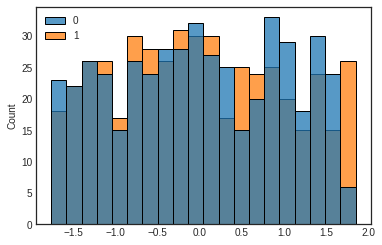

In [7]:
Y = df1.Y.values - 1 # category index, output of dist.Categorical()
print(np.unique(Y))

# standardize
X = df1[['X1', 'X2']].values
meanx = X.mean()
scalex = X.std()
zX = (X - meanx)/scalex

sns.histplot(X, bins=20);

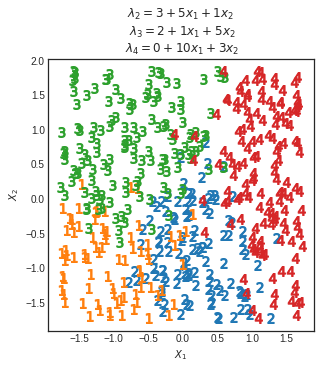

In [8]:
plt.figure(figsize=(5,5))
for outcome in df1.Y.unique():
    plt.scatter(df1[df1.Y == outcome].X1, df1[df1.Y == outcome].X2, s=100, marker='${}$'.format(outcome))
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('$\lambda_2 = 3+5x_1+1x_2$ \n $\lambda_3 = 2+1x_1+5x_2$ \n $\lambda_4 = 0+10x_1+3x_2$')
plt.gca().set_aspect('equal')

### Model

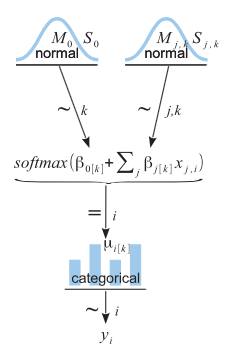

In [9]:
Image('images/fig22_4.png')

In [10]:
n_cat = len(df1.Y.unique())
zX_dim = zX.shape[-1]
print(n_cat, zX_dim)

4 2


In [11]:
def model(zX, y=None):
    zbeta0 = npr.sample('zb0', dist.Normal(0, 20), sample_shape=(n_cat,))
    zbeta = npr.sample('zb', dist.Normal(0, 20), sample_shape=(zX_dim, n_cat))    
    
    mu = zbeta0 + zX @ zbeta
    
    obs = npr.sample('obs', dist.Categorical(logits=mu), obs=y)

### Prior Predictive

In [12]:
data = dict(zX=zX)
s = prior_predictive(model, data)

for k, v in s.items(): print(k, v.shape)

obs (2021, 475)
zb (2021, 2, 4)
zb0 (2021, 4)


In [13]:
np.unique(s['obs'].ravel())

array([0, 1, 2, 3], dtype=int32)

### MCMC inference

In [14]:
ps = mcmc_sampling(model, dict(zX=zX, y=Y))

In [15]:
for k, v in ps.items(): print(k, v.shape)

zb (8000, 2, 4)
zb0 (8000, 4)


### rescale back

In [16]:
# Transform parameters back to original scale
zbeta0 = ps['zb0']
zbeta = ps['zb']

beta0 = zbeta0 - np.sum(zbeta*(np.tile(meanx, (n_cat,1))/np.tile(scalex, (n_cat,1))).T, axis=1)
beta = np.divide(zbeta, np.tile(scalex, (n_cat,1)).T)

print(beta0.shape)
print(beta.shape)

(8000, 4)
(8000, 2, 4)


In [17]:
# Join the two multi-dimensional arrays
estimates1 = np.insert(beta, 0, beta0, axis=1)
estimates1.shape

(8000, 3, 4)

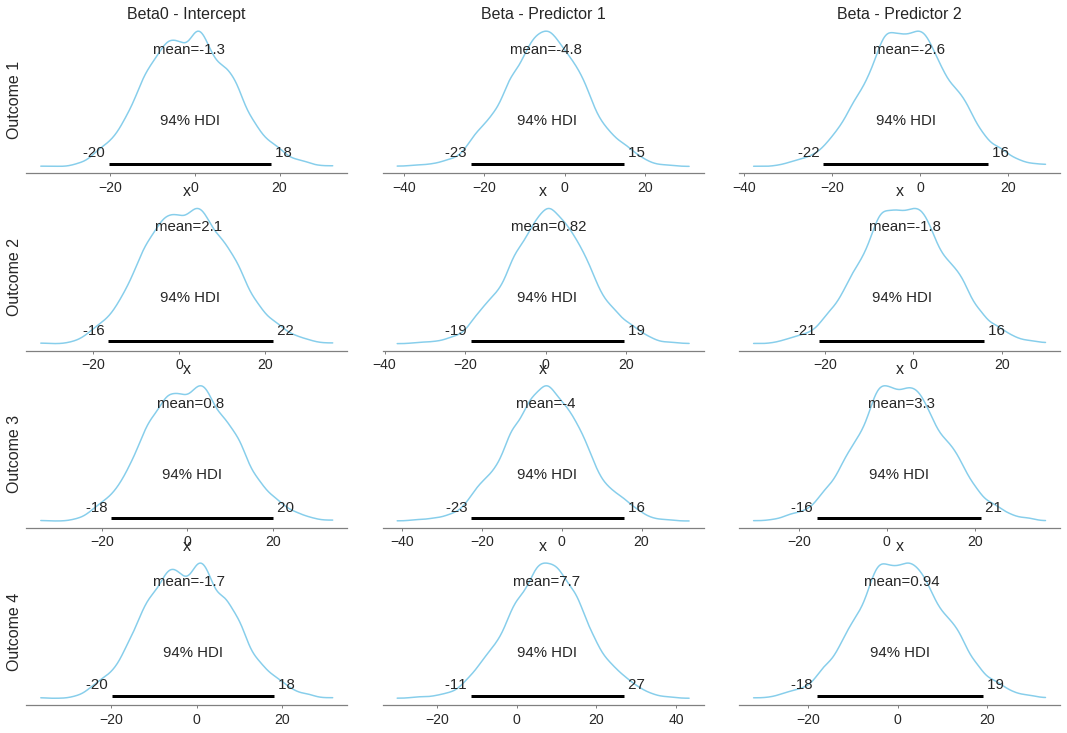

In [18]:
fig, axes = plt.subplots(4,3, figsize=(15,10));
fig.tight_layout()

# Plot the posterior distributions
for (r,c), ax in np.ndenumerate(axes):
    az.plot_posterior(estimates1[:,c,r], point_estimate='mean', color=color, ax=ax)
    
# Setting labels for the outcomes
for r, ax in enumerate(axes[:,0]):
    ax.set_ylabel('Outcome {}'.format(r+1), fontdict=f_dict)

# Setting labels for the predictors
for ax, title in zip(axes[0,:], ['Beta0 - Intercept', 'Beta - Predictor 1', 'Beta - Predictor 2']):
    ax.set_title(title, fontdict=f_dict);

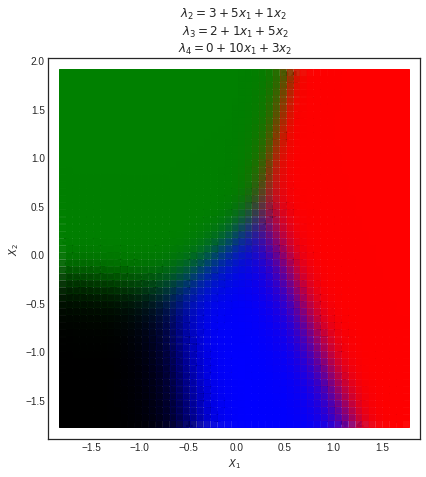

In [60]:
plt.figure(figsize=(7,7))
for outcome in df1.Y.unique():
    plt.scatter(df1[df1.Y == outcome].X1, df1[df1.Y == outcome].X2, s=100, marker='${}$'.format(outcome), color='k')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('$\lambda_2 = 3+5x_1+1x_2$ \n $\lambda_3 = 2+1x_1+5x_2$ \n $\lambda_4 = 0+10x_1+3x_2$')
plt.gca().set_aspect('equal')

# segmentation of the space by hard thresholding w.r.t the posterior mean of beta0 and beta

b0_mean = beta0.mean(axis=0)
b_mean = beta.mean(axis=0)
# print(b0_mean, b_mean)
colors = 'kbgr'
for x1 in np.linspace(df1.X1.min(), df1.X1.max(), 50):
    for x2 in np.linspace(df1.X2.min(), df1.X2.max(), 50):
        
        m = b0_mean + b_mean[0] * x1 + b_mean[1] * x2
        p = scipy.special.softmax(m)
#         i = np.argmax(p)
#         plt.plot(x1, x2, 's', color=colors[i], alpha=p[i])  # alpha is the probability of the max id
        for i in range(4):
            plt.plot(x1, x2, 's', color=colors[i], alpha=p[i], markersize=12)  # alpha is the probability of the max id
        pass
        

#### Mode 2: fix the coordinate system

In [20]:
# the first components of zb0 and zb are set to 0

ref0 = jnp.array([0,1,1,1])

ref = np.ones(shape=(zX_dim, n_cat))
ref[:, 0] = 0
ref = jnp.array(ref)
print(ref0)
print(ref)

def model_2(zX, y=None):
    zbeta0_ = npr.sample('zb0_', dist.Normal(0, 20), sample_shape=(n_cat,))
    zbeta_ = npr.sample('zb_', dist.Normal(0, 20), sample_shape=(zX_dim, n_cat))    

    zbeta0 = npr.deterministic('zb0', zbeta0_ * ref0)
    zbeta = npr.deterministic('zb', zbeta_ * ref)
    
    mu = zbeta0 + zX @ zbeta

    p = softmax(mu)
    
    obs = npr.sample('obs', dist.Categorical(probs=p), obs=y)

[0 1 1 1]
[[0. 1. 1. 1.]
 [0. 1. 1. 1.]]


In [21]:
s = prior_predictive(model_2, dict(zX=zX))

In [22]:
ps = mcmc_sampling(model_2, dict(zX=zX, y=Y))

In [23]:
for k, v in ps.items(): print(k, v.shape)

zb (8000, 2, 4)
zb0 (8000, 4)
zb0_ (8000, 4)
zb_ (8000, 2, 4)


In [24]:
# Transform parameters back to original scale
zbeta0 = ps['zb0']
zbeta = ps['zb']

beta0 = zbeta0 - np.sum(zbeta*(np.tile(meanx, (n_cat,1))/np.tile(scalex, (n_cat,1))).T, axis=1)
beta = np.divide(zbeta, np.tile(scalex, (n_cat,1)).T)

print(beta0.shape)
print(beta.shape)

(8000, 4)
(8000, 2, 4)


In [25]:
# Join the two multi-dimensional arrays
estimates1 = np.insert(beta, 0, beta0, axis=1)
estimates1.shape

(8000, 3, 4)

In [26]:
beta0

array([[ 0.        ,  3.70304608,  2.68975401,  0.4834528 ],
       [-0.        ,  3.60381699,  2.77695656,  0.08112581],
       [-0.        ,  4.22918653,  2.73036504,  0.77136075],
       ...,
       [-0.        ,  3.7081542 ,  1.95153451, -0.79081357],
       [ 0.        ,  3.39909959,  2.4297936 , -0.17443022],
       [-0.        ,  2.41419172,  1.13168502, -1.36293852]])

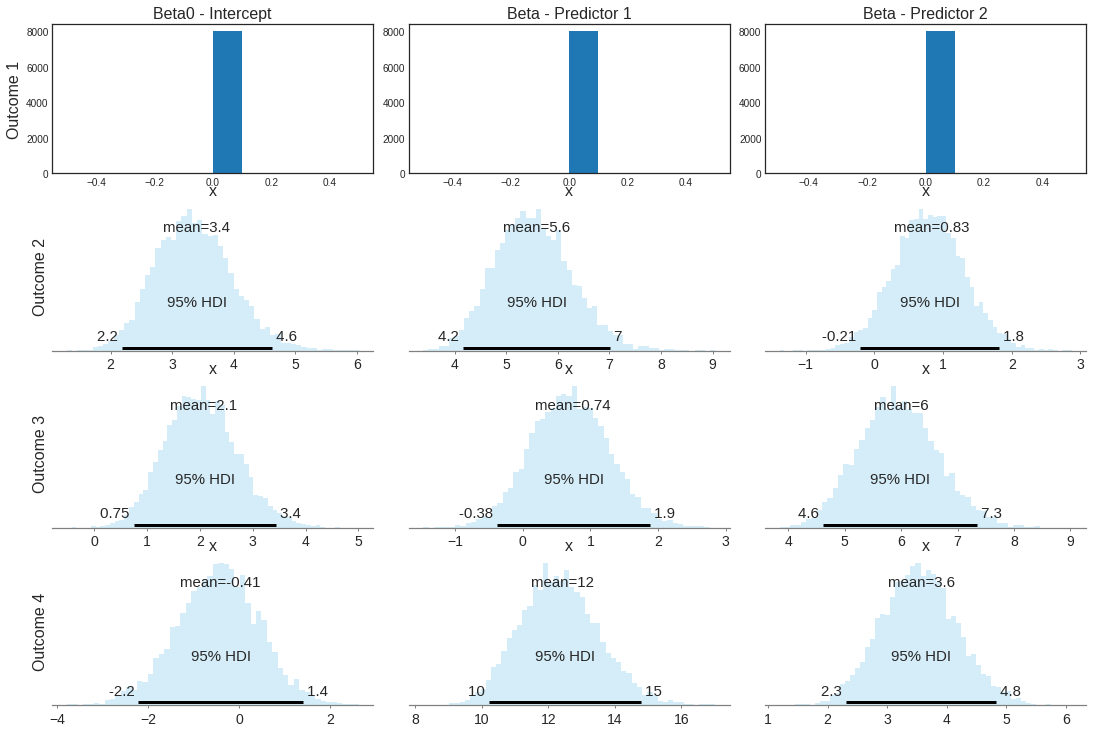

In [27]:
fig, axes = plt.subplots(4,3, figsize=(15,10));
fig.tight_layout()

# Plot the posterior distributions
for (r,c), ax in np.ndenumerate(axes):
    if r > 0:
        az.plot_posterior(estimates1[:,c,r], point_estimate='mean', hdi_prob=.95, color=color, ax=ax, 
                          kind='hist', )
    else:
        ax.hist(estimates1[:,c,r])
    
# Setting labels for the outcomes
for r, ax in enumerate(axes[:,0]):
    ax.set_ylabel('Outcome {}'.format(r+1), fontdict=f_dict)

# Setting labels for the predictors
for ax, title in zip(axes[0,:], ['Beta0 - Intercept', 'Beta - Predictor 1', 'Beta - Predictor 2']):
    ax.set_title(title, fontdict=f_dict);

#### Model 3: fix 

In [28]:
a = jnp.ones((3,))
a.std()

DeviceArray(0., dtype=float32)

In [29]:
def model_3(zX, y=None):
    zbeta0 = npr.sample('zb0_', dist.Normal(0, 20), sample_shape=(n_cat,))
    zbeta = npr.sample('zb_', dist.Normal(0, 20), sample_shape=(zX_dim, n_cat))    

    zbeta0 = zbeta0 - zbeta0[0]
    zbeta  = zbeta  - zbeta[:,:1]

    npr.deterministic('zb0', zbeta0)
    npr.deterministic('zb', zbeta)
    
    mu = zbeta0 + zX @ zbeta
    p = softmax(mu)
    
    obs = npr.sample('obs', dist.Categorical(probs=p), obs=y)

In [30]:
ps = mcmc_sampling(model_3, dict(zX=zX, y=Y))

In [31]:
for k, v in ps.items(): print(k, v.shape)

zb (8000, 2, 4)
zb0 (8000, 4)
zb0_ (8000, 4)
zb_ (8000, 2, 4)


In [32]:
# Transform parameters back to original scale
zbeta0 = ps['zb0']
zbeta = ps['zb']

beta0 = zbeta0 - np.sum(zbeta*(np.tile(meanx, (n_cat,1))/np.tile(scalex, (n_cat,1))).T, axis=1)
beta = np.divide(zbeta, np.tile(scalex, (n_cat,1)).T)

print(beta0.shape)
print(beta.shape)

(8000, 4)
(8000, 2, 4)


In [33]:
# Join the two multi-dimensional arrays
estimates1 = np.insert(beta, 0, beta0, axis=1)
estimates1.shape

(8000, 3, 4)

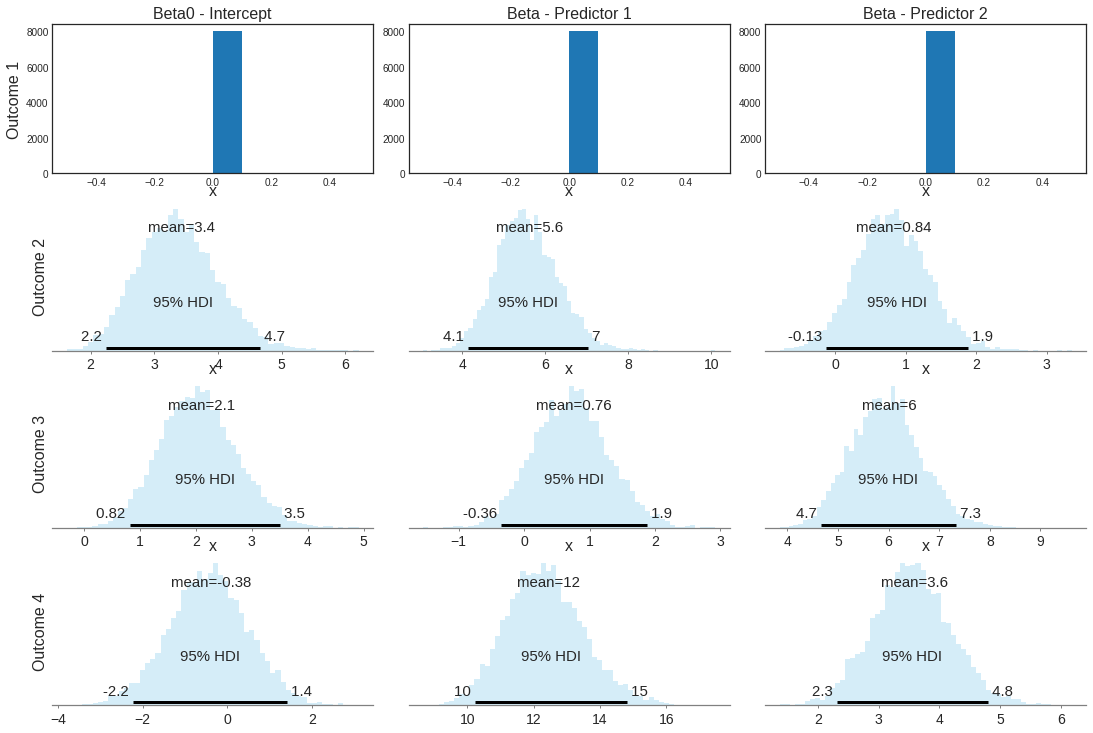

In [34]:
fig, axes = plt.subplots(4,3, figsize=(15,10));
fig.tight_layout()

# Plot the posterior distributions
for (r,c), ax in np.ndenumerate(axes):
    if r > 0:
        az.plot_posterior(estimates1[:,c,r], point_estimate='mean', hdi_prob=.95, color=color, ax=ax, 
                          kind='hist', )
    else:
        ax.hist(estimates1[:,c,r])
    
# Setting labels for the outcomes
for r, ax in enumerate(axes[:,0]):
    ax.set_ylabel('Outcome {}'.format(r+1), fontdict=f_dict)

# Setting labels for the predictors
for ax, title in zip(axes[0,:], ['Beta0 - Intercept', 'Beta - Predictor 1', 'Beta - Predictor 2']):
    ax.set_title(title, fontdict=f_dict);

Hard Clustering Result

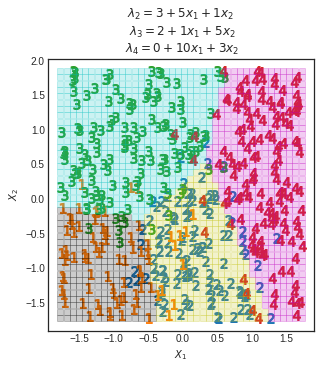

In [35]:
plt.figure(figsize=(5,5))
for outcome in df1.Y.unique():
    plt.scatter(df1[df1.Y == outcome].X1, df1[df1.Y == outcome].X2, s=100, marker='${}$'.format(outcome))
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('$\lambda_2 = 3+5x_1+1x_2$ \n $\lambda_3 = 2+1x_1+5x_2$ \n $\lambda_4 = 0+10x_1+3x_2$')
plt.gca().set_aspect('equal')

# segmentation of the space by hard thresholding w.r.t the posterior mean of beta0 and beta

b0_mean = beta0.mean(axis=0)
b_mean = beta.mean(axis=0)
# print(b0_mean, b_mean)
colors = 'kycm'
for x1 in np.linspace(df1.X1.min(), df1.X1.max(), 40):
    for x2 in np.linspace(df1.X2.min(), df1.X2.max(), 40):
        
        m = b0_mean + b_mean[0] * x1 + b_mean[1] * x2
        p = scipy.special.softmax(m)
        i = np.argmax(p)
        plt.plot(x1, x2, 's', color=colors[i], alpha=.2)
        pass
        